In [1]:
!pip install conllu
!pip install transformers-interpret

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# imports
import conllu
import numpy as np
from tqdm import tqdm

import transformers
from sklearn.model_selection import train_test_split as split


import torch
from transformers import AdamW, get_scheduler
from transformers import BertModel
import io
import os
from torch.utils.data import Dataset,DataLoader,TensorDataset
import transformers
import json
from tqdm.notebook import tqdm
from transformers.utils.dummy_pt_objects import AutoModelForSequenceClassification
from transformers import AutoModelForTokenClassification,AutoConfig, AutoModel,AutoTokenizer,BertModel,BertConfig,AdamW, get_constant_schedule,BertForSequenceClassification,get_linear_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup
import random
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt




import wandb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef,
    classification_report)
import pandas as pd


from transformers import BertTokenizer, TFBertModel, DistilBertTokenizer, DistilBertModel
import tensorflow as tf

#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Data import

In [2]:
# load the conllu dataset
#with open("../data/dataset.conllu") as f:
with open("/content/drive/MyDrive/06_TUWien/09_NLP/data/dataset.conllu") as f:
    data = conllu.parse(f.read())

In [3]:
# extract headlines (since a headline can have more than one sentence)
headlines = []
for i, sentence in enumerate(data):
    if sentence.metadata["sent_id"] == "0":
        headlines.append(data[i:i+1])
    else:
        headlines[-1].append(sentence)

In [4]:
#train test validation split
SEED = 42
tr_data, other_data = split(headlines, test_size=0.3, random_state=SEED)
val_data, ts_data = split(other_data, test_size=0.5, random_state=SEED)

In [5]:
print(len(tr_data))
print(len(val_data))
print(len(ts_data))

20033
4293
4293


In [6]:
import re
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters (including hyphens)
    text = re.sub(r"-", "", text)  # Remove hyphens
    text = text.strip()  # Remove leading/trailing whitespace
    return text

In [7]:
def extract_data(headlines):
    texts = []
    labels = []

    # Extract text and labels
    for headline in headlines:
        text = headline[0].metadata['text']
        label = int(headline[0].metadata['class'])

        text = clean_text(text)

        texts.append(text)
        labels.append(label)

    return texts, labels

tr_texts, tr_labels = extract_data(tr_data)
val_texts, val_labels = extract_data(val_data)
ts_texts, ts_labels = extract_data(ts_data)

#### Data prep

In [8]:
# Initialize the BERT tokenizer
pretrained_model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
# Function to encode the text for BERT (convert text to input_ids and attention_masks)
def encode_data(texts, tokenizer):

    # Tokenize the text using BERT tokenizer
    encoding = tokenizer.batch_encode_plus(
        texts,
        max_length=16,
        truncation = True,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding=True)

    input_ids = encoding['input_ids']  # Remove batch dimension
    attention_masks = encoding['attention_mask']  # Remove batch dimension

    return torch.tensor(input_ids), torch.tensor(attention_masks)

# Prepare the tokenized data for training and testing
tr_tokens, tr_atention = encode_data(tr_texts, tokenizer)
val_tokens, val_atention = encode_data(val_texts, tokenizer)
ts_tokens, ts_atention = encode_data(ts_texts, tokenizer)

In [10]:
# Custom Dataset class, to store raw sentences
class SarcasmDataset(Dataset):
    def __init__(self, tokens, masks, labels, sentences):
        self.tokens = tokens
        self.masks = masks
        self.labels = labels
        self.sentences = sentences

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        return {
            "input_ids": self.tokens[idx],
            "attention_mask": self.masks[idx],
            "label": self.labels[idx],
            "sentence": self.sentences[idx]
        }


def dataloader(tokens, masks, labels, sentences, batch_size=16,  isTrain = False):

    dataset = SarcasmDataset(tokens, masks, torch.tensor(labels), sentences)

    if isTrain == "True":
        loader = DataLoader(dataset, batch_size = batch_size, num_workers=2, shuffle = True, drop_last=True)
    else:
        loader = DataLoader(dataset, batch_size = batch_size, num_workers=2, shuffle = False, drop_last=True)


    return loader

# Prepare the tokenized data and raw sentences
train = dataloader(tr_tokens, tr_atention, tr_labels, tr_texts, batch_size=8, isTrain = True)
validation = dataloader(val_tokens, val_atention, val_labels, val_texts, batch_size=8)
test = dataloader(ts_tokens, ts_atention, ts_labels, ts_texts, batch_size=8)

#### Model setup

In [11]:
from transformers import AutoModelForSequenceClassification, DistilBertConfig

# Load the DistilBERT model's configuration
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')

id2label = {0: "not_sarcastic", 1: "sarcastic"}
label2id = {"not_sarcastic": 0, "sarcastic": 1}

# Modify the dropout rates (increase them as needed)
config.attention_probs_dropout_prob = 0.25  # Default is 0.1
config.hidden_dropout_prob = 0.25  # Default is 0.1
config.num_labels = 2
config.id2label = id2label
config.label2id = label2id


model_ready = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
   # num_labels=2,
    #id2label=id2label,
   # label2id=label2id,
    config=config
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Initialize WandB
wandb.init(
    project="sarcasm-detection",
    config={
        "epochs": 10,
        "batch_size": 8,
        "learning_rate":5e-5,
        "scheduler": "linear",
        "loss_function": "BCELoss"
    }
)

# Training function with progress tracking, early stopping, and WandB logging
def train_bert(model, trainloader, validationloader, device, epochs=10, patience=3):
    # Move model to device
    model.to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

    # Scheduler
    total_training_steps = len(trainloader) * epochs
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1 * total_training_steps, num_training_steps=total_training_steps)

    # Loss function
    loss_function = nn.BCEWithLogitsLoss()

    # Track best validation accuracy and early stopping
    best_validation_accuracy = 0.0
    best_validation_loss = float('inf')
    best_model_state = None
    no_improvement_epochs = 0

    # Metrics for WandB logging
    running_validation_loss = []
    running_training_loss = []
    validation_acc = []
    training_acc = []

    print(f"Starting training for {epochs} epochs with early stopping (patience={patience}).")

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        # Training phase
        model.train()
        total_loss = 0
        correct_predictions = 0

        with tqdm(trainloader, desc="Training", unit="batch") as train_progress:

          for batch in train_progress:
              # Extract batch data
              input_ids = batch["input_ids"]
              attention_mask = batch["attention_mask"]
              labels = batch["label"]
              raw_sentences = batch["sentence"]

              inputs, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

              optimizer.zero_grad()
              outputs = model(inputs, attention_mask)

              logits = outputs.logits
              loss = loss_function(logits[:,1], labels.float()) # selecting the logit for the positive class (sarcastic)


              # Compute loss
              loss.backward()

              optimizer.step()
              scheduler.step()

              total_loss += loss.item()

              # Convert logits to probabilities (if using BCEWithLogitsLoss)
              probabilities = torch.sigmoid(logits[:,1]) # selecting the logit for the positive class (sarcastic)


              # Threshold probabilities to obtain binary predictions
              predictions = (probabilities >= 0.5).float()

              # Calculate accuracy
              correct_predictions += (predictions == labels).sum().item()

              # Update progress bar
              train_progress.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(trainloader.dataset)
        avg_train_accuracy = correct_predictions / len(trainloader.dataset)
        running_training_loss.append(avg_train_loss)
        training_acc.append(avg_train_accuracy)

        print(f"Total loss: {total_loss:.4f}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}")

        # Log training metrics to WandB
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "train_accuracy": avg_train_accuracy
        })

        # Validation phase
        validation_accuracy, validation_loss = validate_bert(model, validationloader, loss_function, device)
        running_validation_loss.append(validation_loss)
        validation_acc.append(validation_accuracy)

        print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

        # Log validation metrics to WandB
        wandb.log({
            "epoch": epoch,
            "val_loss": validation_loss,
            "val_accuracy": validation_accuracy
        })

        # Check for early stopping
        if validation_accuracy > best_validation_accuracy and validation_loss < best_validation_loss:
            best_validation_accuracy = validation_accuracy
            best_validation_loss = validation_loss
            best_model_state = model.state_dict()  # Save the best model state
            no_improvement_epochs = 0
            print("Validation accuracy improved. Best model updated.")
            # Save best model weights to WandB
            torch.save(model.state_dict(), "best_model.pth")
            wandb.save("best_model.pth")
        else:
            no_improvement_epochs += 1
            print(f"No improvement in validation for {no_improvement_epochs} consecutive epoch(s).")

        if no_improvement_epochs >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    # Restore the best model state (if early stopping was triggered)
    if best_model_state:
        model.load_state_dict(best_model_state)

    print("Training completed.")
    return best_validation_accuracy, running_validation_loss, running_training_loss, validation_acc, training_acc


# Validation function
def validate_bert(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():

        for batch in tqdm(dataloader, desc="Validation", unit="batch"):
            # Extract batch data
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["label"]
            raw_sentences = batch["sentence"]

            inputs, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(inputs, attention_mask)

            logits = outputs.logits
           # loss = loss_function(logits, labels)
            loss = loss_function(logits[:,1], labels.float()) # selecting the logit for the positive class (sarcastic)


            # Compute loss
            #loss = loss_function(outputs, labels.float())
            total_loss += loss.item()

            # Convert logits to probabilities (if using BCEWithLogitsLoss)
            probabilities = torch.sigmoid(logits[:,1])

            # Threshold probabilities to obtain binary predictions
            predictions = (probabilities >= 0.5).float()

            # Calculate accuracy
            correct_predictions += (predictions == labels).sum().item()

    accuracy = correct_predictions / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader.dataset)

    return accuracy, avg_loss



def test_bert(model, testloader, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []
    sentences = []

    # Loss function
    loss_function = nn.BCEWithLogitsLoss()

    with torch.no_grad():

        for batch in tqdm(testloader, desc="Testing", unit="batch"):
            # Extract batch data
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["label"]
            raw_sentences = batch["sentence"]

            inputs, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)


            # Model outputs probabilities (sigmoid applied)
            outputs = model(inputs, attention_mask)
            logits = outputs.logits
            #loss = loss_function(logits, labels)
            loss = loss_function(logits[:,1], labels.float()) # selecting the logit for the positive class (sarcastic)


            # Compute loss
            total_loss += loss.item()


            # Convert logits to probabilities (if using BCEWithLogitsLoss)
            probabilities = torch.sigmoid(logits[:,1])

            # Threshold probabilities to obtain binary predictions
            predictions = (probabilities >= 0.5).float()

            labels = labels.cpu().numpy()

            all_probabilities.extend(probabilities.cpu().detach().numpy()) #move to cpu and detach from computation graph
            all_predictions.extend(predictions.cpu().detach().numpy()) #move to cpu and detach from computation graph
            all_labels.extend(labels)
            sentences.extend(raw_sentences)

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_probabilities)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    # Log results to WandB
    wandb.log({
        "test_loss": total_loss / len(testloader.dataset),
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall,
        "test_f1": f1,
        "test_roc_auc": roc_auc,
        "test_mcc": mcc,
    })

    # Create a DataFrame
    df = pd.DataFrame({
        "True Label": all_labels,
        "Predicted Label": all_predictions,
        "Probability": all_probabilities,
        "Sentences": sentences
    })

    # Print metrics
    print("\nTest Metrics:")
    print(f"Loss: {total_loss / len(testloader.dataset):.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Return all metrics
    return {
        "loss": total_loss / len(testloader.dataset),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "mcc": mcc,
        "confusion_matrix": cm,
        "df": df
    }


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ovsvc (ovsvc-tu-wien). Use `wandb login --relogin` to force relogin


In [13]:
def plot_metrics(val_loss, train_loss, val_acc, train_acc):
    # Create a figure and axis
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
    plt.plot(val_loss, label='Validation Loss', color='blue', linestyle='--', marker='o')
    plt.plot(train_loss, label='Training Loss', color='red', linestyle='-', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
    plt.plot(val_acc, label='Validation Accuracy', color='blue', linestyle='--', marker='o')
    plt.plot(train_acc, label='Training Accuracy', color='red', linestyle='-', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


#### Evaluate using ready architecture

In [14]:
# We only want to finetune the classification layer on top of BERT
for p in model_ready.base_model.parameters():
    p.requires_grad = False

In [15]:
for p in model_ready.classifier.parameters():
    print(p.requires_grad)  # Check trainable status

True
True


In [16]:
best_acc, val_loss, train_loss, val_acc, train_acc = train_bert(
    model=model_ready,
    trainloader=train,
    validationloader=validation,
    device="cuda",
    epochs=10,
    patience=5
)
print(f"Best Validation Accuracy: {best_acc:.4f}")

Starting training for 10 epochs with early stopping (patience=5).

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 1462.1656, Training Loss: 0.0730, Training Accuracy: 0.7069


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0587, Validation Accuracy: 0.7866
Validation accuracy improved. Best model updated.

Epoch 2/10


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 1119.5317, Training Loss: 0.0559, Training Accuracy: 0.7955


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0512, Validation Accuracy: 0.8199
Validation accuracy improved. Best model updated.

Epoch 3/10


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 1043.4428, Training Loss: 0.0521, Training Accuracy: 0.8109


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0484, Validation Accuracy: 0.8251
Validation accuracy improved. Best model updated.

Epoch 4/10


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 997.6388, Training Loss: 0.0498, Training Accuracy: 0.8201


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0471, Validation Accuracy: 0.8314
Validation accuracy improved. Best model updated.

Epoch 5/10


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 974.7746, Training Loss: 0.0487, Training Accuracy: 0.8250


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0462, Validation Accuracy: 0.8367
Validation accuracy improved. Best model updated.

Epoch 6/10


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 957.6387, Training Loss: 0.0478, Training Accuracy: 0.8282


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0455, Validation Accuracy: 0.8400
Validation accuracy improved. Best model updated.

Epoch 7/10


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 947.4942, Training Loss: 0.0473, Training Accuracy: 0.8322


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0452, Validation Accuracy: 0.8400
No improvement in validation for 1 consecutive epoch(s).

Epoch 8/10


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 934.9362, Training Loss: 0.0467, Training Accuracy: 0.8330


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0449, Validation Accuracy: 0.8418
Validation accuracy improved. Best model updated.

Epoch 9/10


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 923.7790, Training Loss: 0.0461, Training Accuracy: 0.8358


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0449, Validation Accuracy: 0.8421
Validation accuracy improved. Best model updated.

Epoch 10/10


Training:   0%|          | 0/2504 [00:00<?, ?batch/s]

Total loss: 924.5655, Training Loss: 0.0462, Training Accuracy: 0.8349


Validation:   0%|          | 0/536 [00:00<?, ?batch/s]

Validation Loss: 0.0449, Validation Accuracy: 0.8428
Validation accuracy improved. Best model updated.
Training completed.
Best Validation Accuracy: 0.8428


#### Model quality metrics

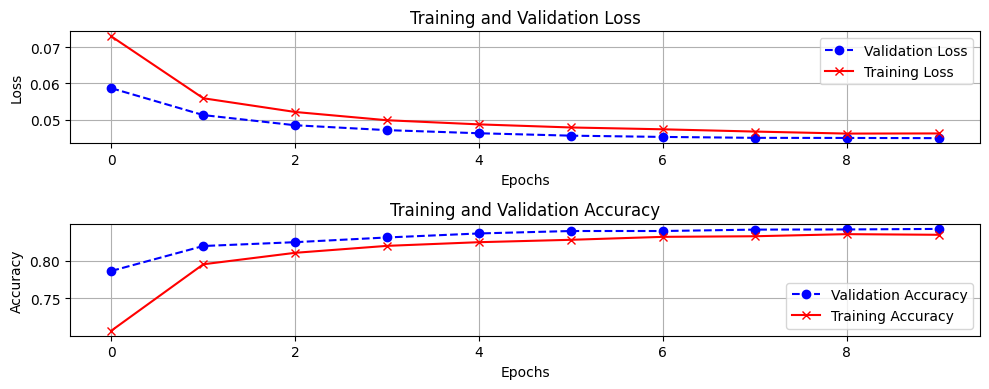

In [17]:
plot_metrics(val_loss, train_loss, val_acc, train_acc)

In [18]:
model_ready.load_state_dict(torch.load("/content/best_model.pth"))
model_ready.to(device)
test_metrics = test_bert(model_ready, test, device)

<ipython-input-18-577391d5ecea>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ready.load_state_dict(torch.load("/content/best_model.pth"))


Testing:   0%|          | 0/536 [00:00<?, ?batch/s]


Test Metrics:
Loss: 0.0447
Accuracy: 0.8407
Precision: 0.8454
Recall: 0.8170
F1-Score: 0.8310
ROC-AUC: 0.9213
MCC: 0.6808
Confusion Matrix:
[[1926  307]
 [ 376 1679]]


#### Misclass analysis

In [19]:
df = test_metrics["df"]

In [20]:
mismatched_df = df[df['True Label'] != df['Predicted Label']]
mismatched_df

,True Label,Predicted Label,Probability,Sentences
1,1,0.0,0.311783,study owning a boat not worth it
12,1,0.0,0.367915,gay conversion therapists claim most patients ...
13,1,0.0,0.472218,repopulation of africa begins
26,0,1.0,0.745897,white terror demands white action what allies ...
31,0,1.0,0.668046,surge soda is back
...,...,...,...,...
4251,1,0.0,0.357848,delirious rover hallucinates water on mars
4255,1,0.0,0.222006,israeli soldiers open fire on palestinians car...
4260,0,1.0,0.612333,radio host pranks the out of cohost
4267,1,0.0,0.048237,mom wants to know if the people who live in yo...


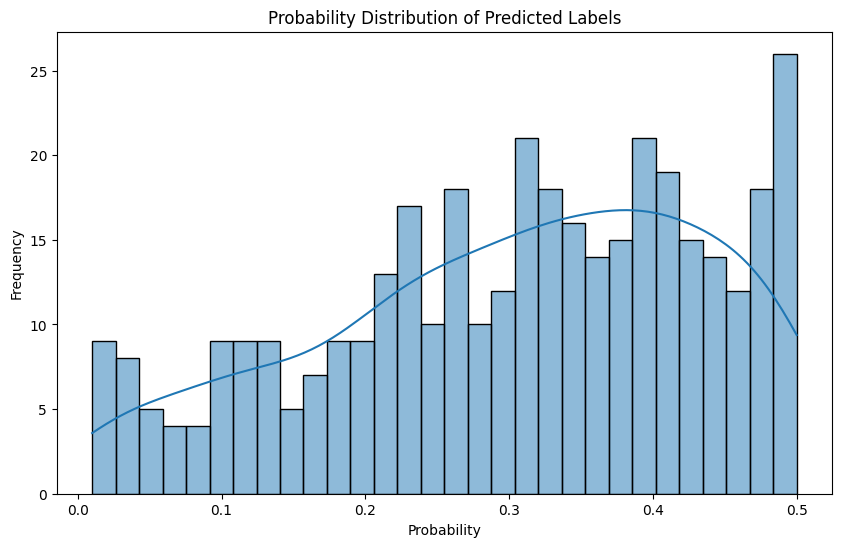

In [21]:
import seaborn as sns

# Create the probability distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(mismatched_df[mismatched_df['True Label']== 1.0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Predicted Labels')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

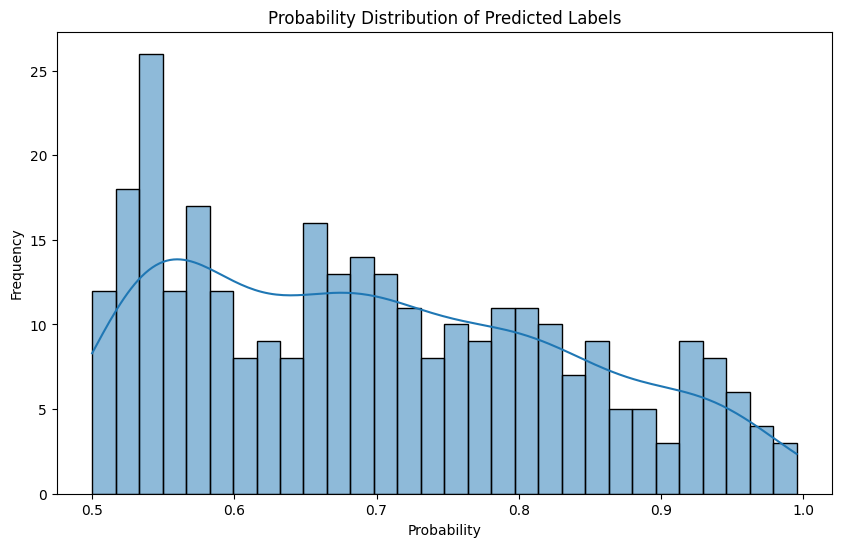

In [22]:

plt.figure(figsize=(10, 6))
sns.histplot(mismatched_df[mismatched_df['True Label']== 0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Predicted Labels')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

Model is not confident near the borders

In [23]:
target_names = target_names = ['Not Sarcastic', 'Sarcastic']
print(classification_report(df["True Label"], df["Predicted Label"], target_names = target_names))

               precision    recall  f1-score   support

Not Sarcastic       0.84      0.86      0.85      2233
    Sarcastic       0.85      0.82      0.83      2055

     accuracy                           0.84      4288
    macro avg       0.84      0.84      0.84      4288
 weighted avg       0.84      0.84      0.84      4288



#### Misclass - tokens

In [24]:
from transformers_interpret import SequenceClassificationExplainer

binary_explainer = SequenceClassificationExplainer(model=model_ready, tokenizer=tokenizer)

In [25]:
def interpret_sentence(sentence):
  word_attributions = binary_explainer(sentence)
  return binary_explainer.visualize()

misclass_sentences = list(mismatched_df["Sentences"])
predicted_labels = list(mismatched_df["Predicted Label"])

for sentence in range(10):
    print(f"Sentence: {misclass_sentences[sentence]}")
    print(f"Predicted Label: {predicted_labels[sentence]}")
    interpret_sentence(misclass_sentences[sentence])

Sentence: study owning a boat not worth it
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.67),not_sarcastic,0.86,[CLS] study owning a boat not worth it [SEP]


Sentence: gay conversion therapists claim most patients fully straight by the time they commit suicide
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.65),not_sarcastic,2.13,[CLS] gay conversion therapist ##s claim most patients fully straight by the time they commit suicide [SEP]


Sentence: repopulation of africa begins
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.55),not_sarcastic,0.30,[CLS] rep ##op ##ulation of africa begins [SEP]


Sentence: white terror demands white action what allies need to do right now for charlottesville
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.67),sarcastic,-1.33,[CLS] white terror demands white action what allies need to do right now for charlotte ##sville [SEP]


Sentence: surge soda is back
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.68),sarcastic,0.58,[CLS] surge soda is back [SEP]


Sentence: supreme court upholds bill of rights in 54 decision
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.78),not_sarcastic,1.73,[CLS] supreme court uphold ##s bill of rights in 54 decision [SEP]


Sentence: interview with louise munson playwright of luigi
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.55),sarcastic,-0.44,[CLS] interview with louise mu ##nson playwright of luigi [SEP]


Sentence: exxonmobil swears its going to start taxes early this year
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.53),not_sarcastic,1.54,[CLS] ex ##xon ##mo ##bil swear ##s its going to start taxes early this year [SEP]


Sentence: biden calls dibs on qaddafis clothes
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.72),not_sarcastic,1.35,[CLS] bid ##en calls di ##bs on q ##ad ##da ##fi ##s clothes [SEP]


Sentence: cupid cop gave out roses cards on valentines day instead of tickets
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.66),sarcastic,-0.75,[CLS] cup ##id cop gave out roses cards on valentine ##s day instead of tickets [SEP]


In [26]:
from collections import defaultdict

# Initialize dictionaries to store positive and negative counts for each token
positive_token_counts = defaultdict(int)
negative_token_counts = defaultdict(int)

# Define a function to interpret a sentence and aggregate scores
def interpret_sentence_and_aggregate(sentence ):
    word_attributions = binary_explainer(sentence)

    # Extract tokens and scores from word_attributions
    for token, score in word_attributions:  # Assuming word_attributions is a list of (token, score)
        if score > 0:
            positive_token_counts[token] += 1
        elif score < 0:
            negative_token_counts[token] += 1

# Iterate over sentences
misclass_sentences = list(mismatched_df["Sentences"])
predicted_labels = list(mismatched_df["Predicted Label"])

for sentence in misclass_sentences:
    interpret_sentence_and_aggregate(sentence)

In [27]:
# Calculate total counts for positive and negative tokens
total_positive_tokens = sum(positive_token_counts.values())
total_negative_tokens = sum(negative_token_counts.values())

# Calculate percentage contributions
positive_token_percentages = {
    token: (count / total_positive_tokens) * 100 for token, count in positive_token_counts.items()
}
negative_token_percentages = {
    token: (count / total_negative_tokens) * 100 for token, count in negative_token_counts.items()
}

# Sort and get top 10 tokens for positive and negative percentages
top_positive_tokens = sorted(positive_token_percentages.items(), key=lambda x: x[1], reverse=True)[:20]
top_negative_tokens = sorted(negative_token_percentages.items(), key=lambda x: x[1], reverse=True)[:20]

# Print the top 10 results with percentages
print("Top 10 tokens more often positive (as percentage of total):")
for token, percentage in top_positive_tokens:
    print(f"{token}: {percentage:.2f}%")

print("\nTop 10 tokens more often negative (as percentage of total):")
for token, percentage in top_negative_tokens:
    print(f"{token}: {percentage:.2f}%")


Top 10 tokens more often positive (as percentage of total):
to: 2.53%
##s: 2.18%
of: 1.78%
in: 1.17%
for: 1.07%
the: 0.92%
on: 0.65%
a: 0.59%
trump: 0.59%
you: 0.54%
at: 0.52%
by: 0.44%
after: 0.44%
from: 0.44%
who: 0.38%
new: 0.36%
into: 0.36%
man: 0.36%
your: 0.36%
with: 0.34%

Top 10 tokens more often negative (as percentage of total):
to: 3.54%
##s: 2.24%
of: 2.15%
in: 1.74%
for: 1.39%
on: 0.98%
a: 0.92%
the: 0.85%
new: 0.76%
with: 0.70%
and: 0.60%
by: 0.54%
after: 0.51%
trump: 0.47%
##t: 0.47%
at: 0.41%
this: 0.35%
up: 0.35%
from: 0.32%
has: 0.32%
